In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset , DataLoader
from sklearn.model_selection import train_test_split

In [2]:
torch.manual_seed(42)

In [3]:
!kaggle datasets download -d zalando-research/fashionmnist

Dataset URL: https://www.kaggle.com/datasets/zalando-research/fashionmnist
License(s): other
 68% 47.0M/68.8M [00:00<00:00, 252MB/s]
100% 68.8M/68.8M [00:00<00:00, 260MB/s]


In [4]:
!unzip fashionmnist.zip

Archive:  fashionmnist.zip
  inflating: fashion-mnist_test.csv  
  inflating: fashion-mnist_train.csv  
  inflating: t10k-images-idx3-ubyte  
  inflating: t10k-labels-idx1-ubyte  
  inflating: train-images-idx3-ubyte  
  inflating: train-labels-idx1-ubyte  


In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [6]:
df = pd.read_csv('/content/fashion-mnist_train.csv')

In [7]:
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


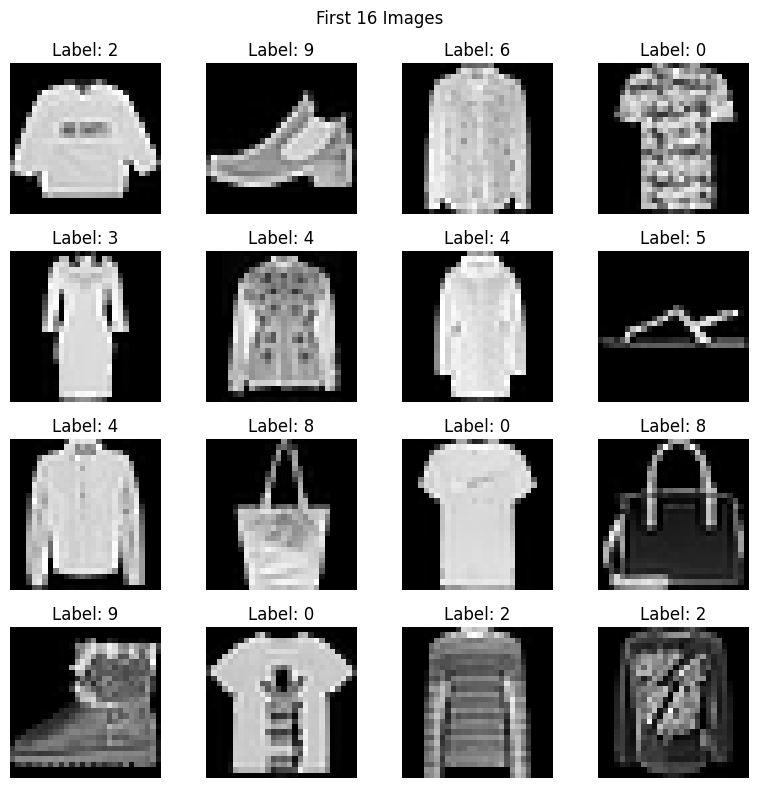

In [8]:
# Create figure and set size
plt.figure(figsize=(8, 8))
plt.suptitle("First 16 Images")

# Loop through the first 16 images
for i in range(16):
    plt.subplot(4, 4, i + 1)  # Create a 4x4 grid of subplots (position starts at 1)

    # Extract image data from DataFrame, reshape to 28x28 pixels
    img = df.iloc[i, 1:].values.reshape(28, 28)

    # Display image in grayscale
    plt.imshow(img, cmap='gray')
    plt.axis('off')  # Hide axis for better visualization

    # Add title showing the label
    plt.title(f"Label: {df.iloc[i, 0]}")

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the figure
plt.show()


In [9]:
X = df.iloc[:,1:].values
y = df.iloc [:,0].values

In [10]:
X_train , X_test , y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [11]:
len(X_train) , len(X_test)

(48000, 12000)

In [12]:
# Scaling the dataset
X_train = X_train/255
X_test = X_test/255

In [13]:
X_train

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.00392157, 0.        ,
        0.        ]])

In [14]:
X_train.shape , y_train.shape

((48000, 784), (48000,))

In [15]:
class CustomDataSet (Dataset) :
  def __init__(self,features,labels) :
    self.features = torch.tensor(features,dtype=torch.float32)
    self.labels = torch.tensor(labels,dtype=torch.long)

  def __len__(self) :
    return len(self.features)

  def __getitem__(self, index) :
    return self.features[index],self.labels[index]

In [16]:
train_data = CustomDataSet(X_train,y_train)
test_data = CustomDataSet(X_test,y_test)


In [17]:
len(train_data) , len(test_data)

(48000, 12000)

In [18]:
train_loader = DataLoader(train_data,batch_size=32,shuffle=True,pin_memory=True)
test_loader = DataLoader(test_data,batch_size=32,shuffle=False,pin_memory=True)

In [20]:
# Building ANN Model
class My_ANN (nn.Module) :
  def __init__(self,input_features) :
    super().__init__()
    self.model = nn.Sequential(
        nn.Linear(in_features=input_features,out_features=128),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.Dropout(p=0.3),
        nn.Linear(in_features=128,out_features=64),
        nn.BatchNorm1d(64),
        nn.ReLU(),
        nn.Dropout(p=0.3),
        nn.Linear(in_features=64,out_features=10)
    )

  def forward (self , x) :
    return self.model(x)


In [21]:
model_1 = My_ANN(X_train.shape[1]).to(device)

In [22]:
next(model_1.parameters()).device


device(type='cuda', index=0)

In [23]:
def accuracy (y_true,y_pred) :
  correct = torch.eq(y_true,y_pred).sum().item()
  acc = (correct/len(y_pred))*100
  return acc

In [24]:
# Initializing the loss and optimizer
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=model_1.parameters() , lr=0.1 , weight_decay=1e-4)

In [25]:
epochs = 15
for epoch in range (epochs) :
  total_epoch_loss = 0
  for batch_features , batch_labels in train_loader :
    batch_features = batch_features.to(device)
    batch_labels = batch_labels.to(device)
    # forward pass
    model_1.train()

    y_pred = model_1(batch_features)
    #calculating the loss
    loss = loss_fn(y_pred,batch_labels)
    acc = accuracy (batch_labels,y_pred.argmax(dim=1))
    # backpropagation
    optimizer.zero_grad()
    loss.backward()

    # update parameters
    optimizer.step()

    total_epoch_loss += loss.item()

  avg_loss = total_epoch_loss / len(train_loader)


  print(f"Epoch : {epoch} | Loss : {avg_loss} ")


Epoch : 0 | Loss : 0.6249084644317627 
Epoch : 1 | Loss : 0.4919969036479791 
Epoch : 2 | Loss : 0.455620892132322 
Epoch : 3 | Loss : 0.4338064221441746 
Epoch : 4 | Loss : 0.41715061252812546 
Epoch : 5 | Loss : 0.4056409275531769 
Epoch : 6 | Loss : 0.39416088837385177 
Epoch : 7 | Loss : 0.3858017429014047 
Epoch : 8 | Loss : 0.37439838365713757 
Epoch : 9 | Loss : 0.37257265872259937 
Epoch : 10 | Loss : 0.36783314737677575 
Epoch : 11 | Loss : 0.35720522227386636 
Epoch : 12 | Loss : 0.3505206037561099 
Epoch : 13 | Loss : 0.3449219425916672 
Epoch : 14 | Loss : 0.34472561853379013 


In [29]:
model_1.eval()

# evaluation code
total = 0
correct = 0
i= 0
with torch.inference_mode():

  for batch_features, batch_labels in test_loader:
    batch_features = batch_features.to(device)
    batch_labels = batch_labels.to(device)
    outputs = model_1(batch_features)

    predicted = torch.argmax(outputs, 1)

    total = total + batch_labels.shape[0]
    correct = correct + (predicted == batch_labels).sum().item()
# print(total)
# print(correct)
print(correct/total)


0.8846666666666667


In [30]:
total =0
correct = 0

with torch.inference_mode() :
  for batch_features , batch_labels in train_loader :
    batch_features = batch_features.to(device)
    batch_labels = batch_labels.to(device)
    outputs = model_1(batch_features)

    predicted = torch.argmax(outputs,1)

    total += batch_labels.shape[0]
    correct += (predicted == batch_labels).sum().item()

print(correct/total)

0.91325
